---
title: More on Sinusoidal Models
---

## Sunspots Dataset

In [231]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

To this sunspots dataset, we shall fit the sinusoidal model: 
\begin{equation*}
  y_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin(2 \pi f t) + \epsilon_t
\end{equation*}
with $\epsilon_t$ being i.i.d $N(0, \sigma^2)$. We focus on estimation and uncertainty quantification for the important parameter in this model is $f$. We do this in two ways: (a) using Fourier frequencies, and (b) using a dense grid of frequencies, and we compare the results. 

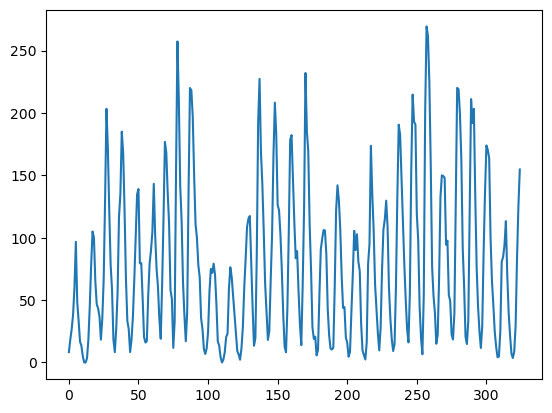

In [232]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
y = sunspots.iloc[:,1].values
n = len(y)
plt.plot(y)
plt.show()

When restricting to Fourier frequencies, computation of $RSS(f)$ proceeds via the DFT and periodogram. Here is the code for computing the periodogram.

In [233]:
def periodogram(y):
    fft_y = np.fft.fft(y) #this computation is very fast O(n log n)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y


Below we plot the periodogram. 

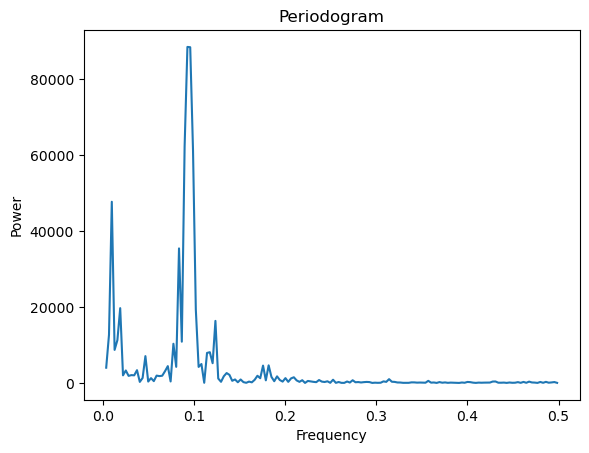

In [234]:
freqs, pgram = periodogram(y)
plt.plot(freqs, pgram)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Periodogram')
plt.show()

Below is the code for computing the RSS using the periodogram.

In [235]:
def rss_periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    var_y = np.sum((y - np.mean(y)) ** 2)
    rssvals = var_y - 2*pgram_y
    return fourier_freqs, rssvals

The following is the plot for the RSS (restricted to Fourier frequencies in the range $(0, 0.5)$):

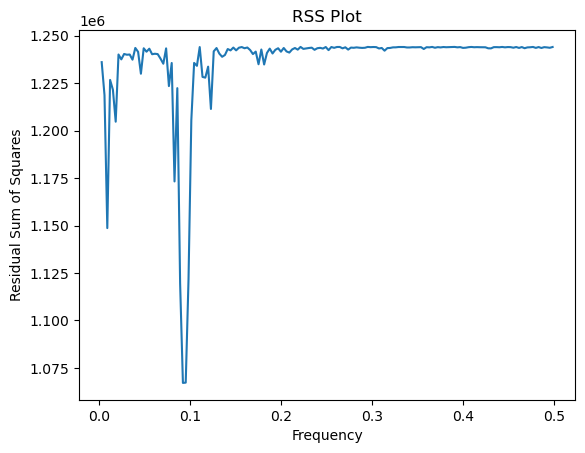

In [236]:
freqs, rssvals = rss_periodogram(y)
plt.plot(freqs, rssvals)
plt.xlabel('Frequency')
plt.ylabel('Residual Sum of Squares')
plt.title('RSS Plot')
plt.show()

Below is the estimate of $f$ (along with the corresponding period) based on this RSS. It is simply the minimizer of RSS (or equivalently, maximizer of the periodogram):

In [237]:
#Estimate of f and the corresponding period: 
fhat = freqs[np.argmax(pgram)]
print(fhat)
period_hat = 1/fhat
print(period_hat)

0.09230769230769231
10.833333333333332


The estimate of the period is somewhat close to 11 but not very close. Let us now do uncertainty quantification (again with the restriction to Fourier frequencies) to see how wide the uncertainty interval for $f$ is. The following function calculates the posterior for $f$ on the log-scale. Recall that the posterior is given by: 
\begin{align*}
  \text{posterior}(j/n) \propto \left(\frac{1}{RSS(j/n)} \right)^{(n-3)/2} I\{0 < j/n < 0.5\}.
\end{align*}
Note that there is no term $|X_f^T X_f|^{-1/2}$ as this term is a constant (not depending on $f$) when $f$ is restricted to Fourier frequencies. In the function below, we compute this posterior on the log-scale, and we use the connection between RSS and periodogram to compute the RSS. 

In [238]:
#Uncertainty quantification for f: 
def logpost_periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, (1/2) + (1/n), 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    var_y = np.sum((y - np.mean(y)) ** 2)
    rssvals = var_y - 2*pgram_y
    p = 3
    logpostvals = ((p-n)/2) * np.log(rssvals)
    return fourier_freqs, logpostvals

Below we plot the log posterior as a function of the fourier frequencies. 

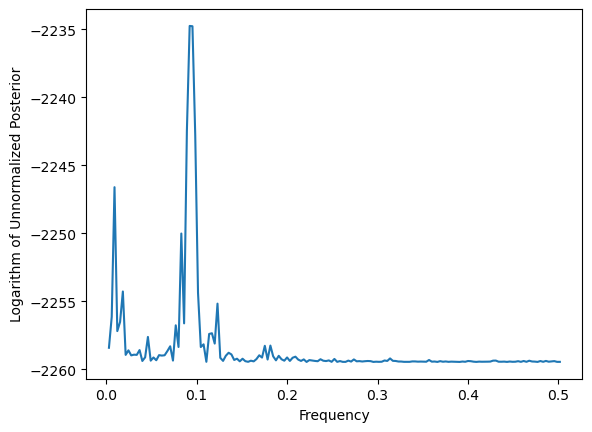

In [239]:
freqs, logpostvals = logpost_periodogram(y)
plt.plot(freqs, logpostvals)
plt.xlabel('Frequency')
plt.ylabel('Logarithm of Unnormalized Posterior')
plt.show()

Below we exponentiate the log-posterior to compute the posterior (and subsequently normalize the posterior). We then compute the posterior mode, and the smallest symmetric region around the posterior mode for which the posterior probability exceeds 0.95. This will give our uncertainty interval for $f$. Note again that in this analysis, we are restricting $f$ to the set of Fourier frequencies. 

In [240]:
freqs, logpostvals = logpost_periodogram(y)
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized/(np.sum(postvals_unnormalized))

def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m+1)])
    return(ans)
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
est_ind = np.argmax(postvals)
f_est = freqs[est_ind]
#95% credible interval for f:
ci_f_low = freqs[est_ind - m]
ci_f_high = freqs[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high]))

period_est = 1/f_est
ci_period_low = 1/ci_f_high
ci_period_high = 1/ci_f_low
print(np.array([ci_period_low, period_est, ci_period_high]))


[0.09230769 0.08923077 0.09538462]
[10.48387097 10.83333333 11.20689655]


For better interpretation of the uncertainty interval, let us convert the uncertainty range into days (as opposed to years). This gives: 

In [242]:
np.array([(period_est - ci_period_low)*365, (ci_period_high - period_est)*365])

array([127.55376344, 136.35057471])

Note that this interval for the period ($1/f$) is not symmetric because we took inverses (the interval for $f$ is symmetric). 

The point estimate and the credible interval can be summarized as: 
\begin{equation*}
   [10.83 \text{ years } - 127 \text{ days }, 10.83 \text{ years } + 136 \text{ days }]
\end{equation*}

Here we are losing something in doing the analysis through Fourier frequencies. If we instead use a much finer grid of frequencies, we will get a much narrower uncertainty for $f$ and the period. This is illustrated below. 

In [243]:
def logpost(f):
    n = len(y)
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) #sgn gives the sign of the determinant (in our case, this should 1)
    #log_det gives the logarithm of the absolute value of the determinant
    logval = ((p-n)/2) * np.log(rss) - (0.5)*log_det
    return logval

allfvals = np.arange(0.01, 0.5, .0001) #much finer grid
logpostvals = np.array([logpost(f) for f in allfvals])
postvals = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals/(np.sum(postvals))
print(allfvals[np.argmax(postvals)])
print(1/allfvals[np.argmax(postvals)])


0.09089999999999951
11.00110011001106


In [244]:
def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m+1)])
    return(ans)
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
est_ind = np.argmax(postvals)
f_est = allfvals[est_ind]
#95% credible interval for f:
ci_f_low = allfvals[est_ind - m]
ci_f_high = allfvals[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high]))

period_est = 1/f_est
ci_period_low = 1/ci_f_high
ci_period_high = 1/ci_f_low
print(np.array([ci_period_low, period_est, ci_period_high]))

[0.0909 0.0906 0.0912]
[10.96491228 11.00110011 11.03752759]


In [245]:
np.array([(period_est - ci_period_low)*365, (ci_period_high - period_est)*365])

array([13.2085577 , 13.29603159])

So the uncertainty period can be summarized as:
\begin{equation*}
   [11 \text{ years } - 13 \text{ days}, 11 \text{ years } + 13 \text{ days}]
\end{equation*}
which is much narrower compared to the previous estimate of the period based only on Fourier frequencies. 

## Fitting more sinusoids to the sunspots data

We now consider the model with two sinusoids: 
\begin{equation*}
  y_t = \beta_0 + \beta_1 \cos(2 \pi f_1 t) + \beta_2 \sin(2 \pi f_1 t) + \beta_3 \cos(2 \pi f_2 t) + \beta_4 \sin(2 \pi f_2 t) + \epsilon_t
\end{equation*}
with both $f_1$ and $f_2$ denoting unknown parameters (along with $\beta_0, \beta_1, \beta_2, \beta_3, \beta_4$ and $\sigma$).

Before fitting this model to the data, let us first compute the fitted values for the best single sinusoidal model (that we fit above). 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     70.27
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           4.74e-26
Time:                        16:22:56   Log-Likelihood:                -1742.9
No. Observations:                 325   AIC:                             3492.
Df Residuals:                     322   BIC:                             3503.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.8755      2.877     27.414      0.0

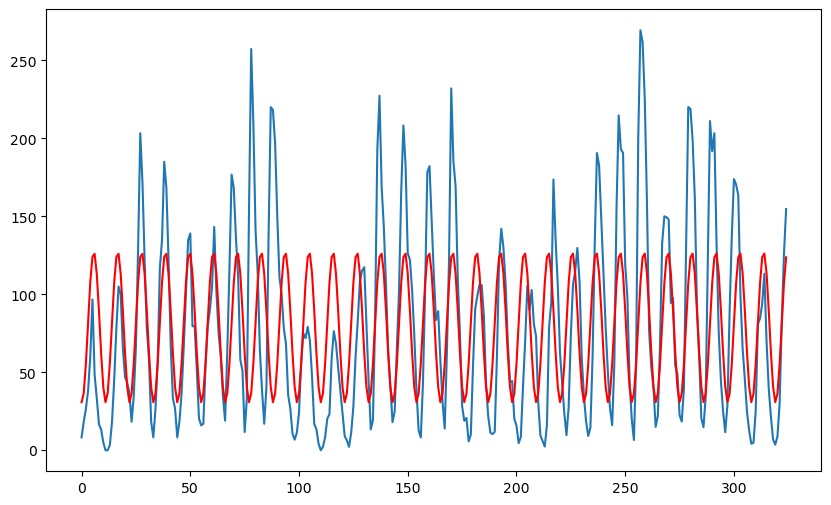

In [246]:
n = len(y)
f = f_est
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n)])
x = np.arange(1, n+1)
if np.isscalar(f):
    f = [f]
for j in range(len(f)):
    f1 = f[j]
    xcos = np.cos(2 * np.pi * f1 * x)
    xsin = np.sin(2 * np.pi * f1 * x)
    X = np.column_stack([X, xcos, xsin])

md_1 = sm.OLS(y, X).fit()
print(md_1.summary())
best_rss_1 = np.sum(md_1.resid ** 2)
print(best_rss_1)

plt.figure(figsize = (10, 6))
#plt.plot(y, linestyle = '', marker = '')
plt.plot(y)
#plt.plot(md1.fittedvalues, color = 'red', marker = '', linestyle = '')
#plt.plot(md2.fittedvalues, color = 'black', marker = '', linestyle = '')
plt.plot(md_1.fittedvalues, color = 'red')
plt.show()

Below we write a function for calculating RSS with multiple frequencies. 

In [247]:
def rss(f):
    n = len(y)
    X = np.column_stack([np.ones(n)])
    x = np.arange(1, n+1)
    if np.isscalar(f):
        f = [f]
    for j in range(len(f)):
        f1 = f[j]
        xcos = np.cos(2 * np.pi * f1 * x)
        xsin = np.sin(2 * np.pi * f1 * x)
        X = np.column_stack([X, xcos, xsin])
    md = sm.OLS(y, X).fit()
    ans = np.sum(md.resid ** 2)
    return ans


In the code below, we search over two frequencies $f_1$ and $f_2$ which best fit to the data. For the range of frequencies, we restrict to the range $(0, 0.15)$. This is because it seems unlikely that sinusoids with frequencies larger than 0.15 will fit well to the data. 

In [248]:
f1_gr = np.linspace(0, 0.15, 1000)
f2_gr = np.linspace(0, 0.15, 1000)
# mesh on the 3 axes; 'ij' preserves axis ordering
X, Y = np.meshgrid(f1_gr, f2_gr, indexing='ij')
# keep only nondecreasing triples to kill permutations:
mask = (X <= Y)
xf, yf = X[mask], Y[mask]
def _rss3(x, y):
    return rss([float(x), float(y)])
rss_vec = np.vectorize(_rss3)   
rss_vals = rss_vec(xf, yf)
g = pd.DataFrame({'x': xf, 'y': yf, 'rss': rss_vals})

In [249]:
min_row = g.loc[g['rss'].idxmin()]
print(min_row)
f_opt_2 = np.array([min_row['x'], min_row['y']])
print(f_opt_2)
print(1/f_opt_2)

x           0.090691
y           0.099850
rss    702139.356644
Name: 421955, dtype: float64
[0.09069069 0.09984985]
[11.02649007 10.01503759]


Below we plot the fitted function with the two best frequencies obtained as above. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     61.75
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           1.26e-38
Time:                        16:28:55   Log-Likelihood:                -1708.8
No. Observations:                 325   AIC:                             3428.
Df Residuals:                     320   BIC:                             3447.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.0015      2.599     30.398      0.0

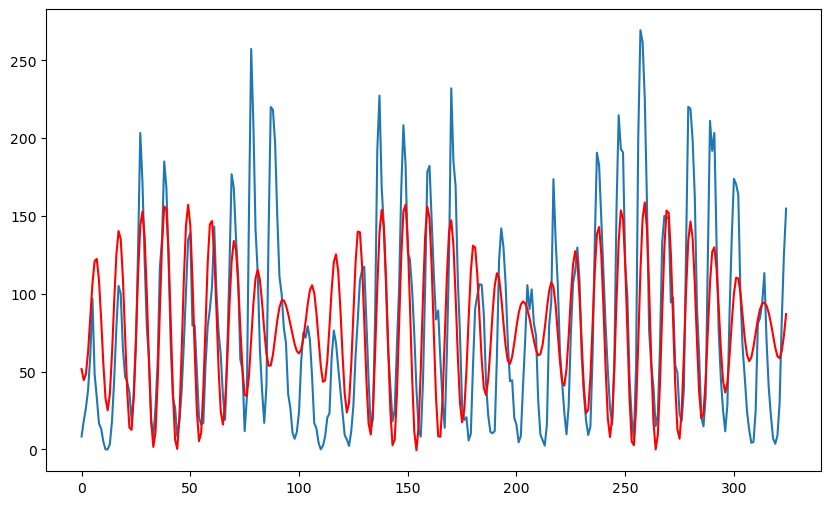

In [251]:
n = len(y)
f = f_opt_2 #f_opt was obtained from the grid minimization
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n)])
x = np.arange(1, n+1)
if np.isscalar(f):
    f = [f]
for j in range(len(f)):
    f1 = f[j]
    xcos = np.cos(2 * np.pi * f1 * x)
    xsin = np.sin(2 * np.pi * f1 * x)
    X = np.column_stack([X, xcos, xsin])

md_2 = sm.OLS(y, X).fit()
print(md_2.summary())
best_rss_2 = np.sum(md_2.resid ** 2)
print(best_rss_2)


plt.figure(figsize = (10, 6))
#plt.plot(y, linestyle = '', marker = '')
plt.plot(y)
#plt.plot(md_1.fittedvalues, color = 'black')
#plt.plot(md2.fittedvalues, color = 'black', marker = '', linestyle = '')
plt.plot(md_2.fittedvalues, color = 'red')
plt.show()

Next we try to find the three best frequencies, again using a grid minimization strategy. 

In [252]:
f1_gr = np.linspace(0, 0.15, 200)
f2_gr = np.linspace(0, 0.15, 200)
f3_gr = np.linspace(0, 0.15, 200)
# mesh on the 3 axes; 'ij' preserves axis ordering
X, Y, Z = np.meshgrid(f1_gr, f2_gr, f3_gr, indexing='ij')
# keep only nondecreasing triples to kill permutations:
mask = (X <= Y) & (Y <= Z)
xf, yf, zf = X[mask], Y[mask], Z[mask]
def _rss3(x, y, z):
    return rss([float(x), float(y), float(z)])
rss_vec = np.vectorize(_rss3)   
rss_vals = rss_vec(xf, yf, zf)
g = pd.DataFrame({'x': xf, 'y': yf, 'z': zf, 'rss': rss_vals})

In [253]:
min_row = g.loc[g['rss'].idxmin()]
print(min_row)
f_opt_3 = np.array([min_row['x'], min_row['y'], min_row['z']])
print(f_opt_3)
print(1/f_opt_3)

x           0.091206
y           0.093467
z           0.100251
rss    580238.083040
Name: 1268323, dtype: float64
[0.09120603 0.09346734 0.10025126]
[10.96418733 10.69892473  9.97493734]


Next we plot the fitted function using the three best frequencies.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     60.64
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           7.93e-50
Time:                        16:35:57   Log-Likelihood:                -1677.9
No. Observations:                 325   AIC:                             3370.
Df Residuals:                     318   BIC:                             3396.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.7632      2.370     33.229      0.0

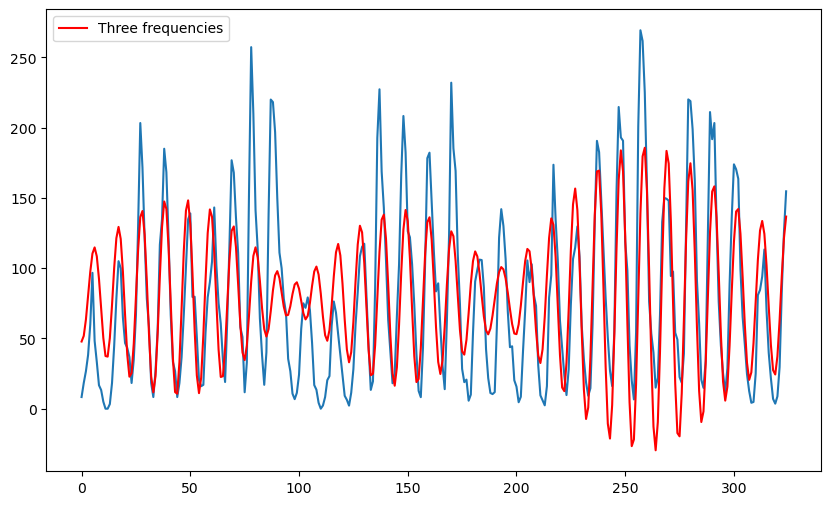

In [255]:
n = len(y)
f = f_opt_3 #f_opt was obtained from the grid minimization
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n)])
x = np.arange(1, n+1)
if np.isscalar(f):
    f = [f]
for j in range(len(f)):
    f1 = f[j]
    xcos = np.cos(2 * np.pi * f1 * x)
    xsin = np.sin(2 * np.pi * f1 * x)
    X = np.column_stack([X, xcos, xsin])

md_3 = sm.OLS(y, X).fit()
print(md_3.summary())
best_rss_3 = np.sum(md_3.resid ** 2)
print(best_rss_3)


plt.figure(figsize = (10, 6))
#plt.plot(y, linestyle = '', marker = '')
plt.plot(y)
#plt.plot(md_1.fittedvalues, color = 'red', label = 'One frequency')
#plt.plot(md_2.fittedvalues, color = 'black', label = 'Two frequencies')
plt.plot(md_3.fittedvalues, color = 'red', label = 'Three frequencies')
plt.legend()
plt.show()

Below we look at the smallest RSS achieved with one frequency, two frequencies and three frequencies respectively. 

In [256]:
print(np.array([best_rss_1, best_rss_2, best_rss_3]))

[866098.0246371  702139.35664397 580238.08304047]


If, instead of trying to find the best frequencies, we only look at the Fourier frequencies, the RSS will be much higher. 

In [260]:
print(rss([30/n, 31/n, 29/n]))

765576.0204283749


The best Fourier frequencies can be found as follows (these are the maximizers of the periodogram): 

In [257]:
print(n * freqs[np.argsort(pgram)[::-1]])

[ 30.  31.  29.  32.   3.  27.   6.  33.  40.   2.   5.  28.  25.   4.
  38.  37.  15.  39.  35.  59.  57.  23.  26.  34.   1.  12.   8.  22.
  44.  45.  10.  11.   7.  19.  21.  55.   9.  20.  43.  62.  60.  68.
  14.  65.  17.  56.  67.  41. 102.  47.  49.  82.  54.  77.  63.  71.
  89.  58.  69.  46. 116.  73.  18.  61.  80. 100.  74.  24. 140.  87.
 139.  16.  64.  52.  78. 152. 103.  42.  70.  75. 101.  66. 158.  13.
 104. 150.  94. 130. 156.  79.  84.  91. 161.  95. 120.  50.  93. 148.
 131.  76.  90.  48.  53. 110. 111. 122. 160. 153.  92. 105. 118. 145.
 128. 106. 113.  88. 138. 154. 143. 134. 124. 114. 136. 112. 117. 137.
 132.  97. 159. 141. 125. 147. 121. 115. 142. 126.  99. 135. 129.  36.
 108. 157. 146. 151.  51.  81. 109. 123.  98. 107.  83. 149. 162.  85.
  86. 133. 144. 155. 119.  96.  72. 127.]


In [ ]:
print(rss([30/n, 31/n, 29/n, 32/n]))
print([30/n, 31/n, 29/n, 32/n])
print(f_opt_3)

Below we plot the best fitted function with the top 5 Fourier frequencies. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     39.94
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           3.02e-50
Time:                        16:42:39   Log-Likelihood:                -1668.5
No. Observations:                 325   AIC:                             3359.
Df Residuals:                     314   BIC:                             3401.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.7600      2.317     34.000      0.0

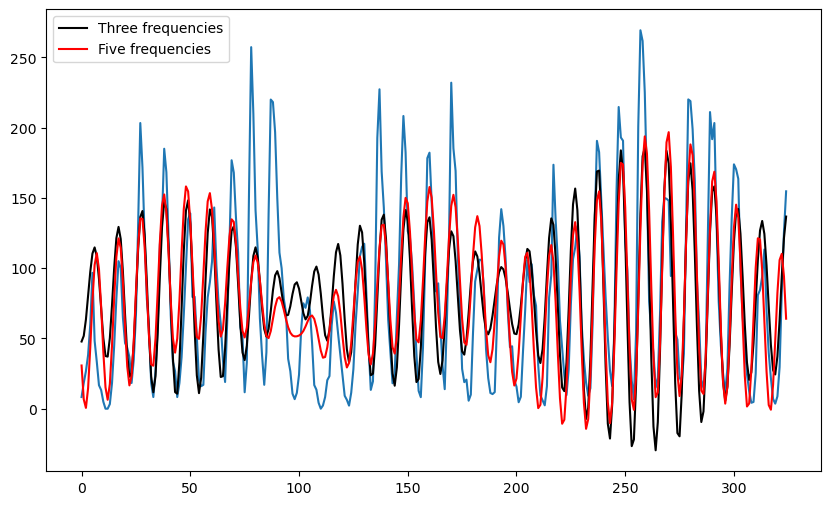

In [265]:
n = len(y)
f = [30/n, 31/n, 29/n, 32/n, 3/n] #f_opt was obtained from the grid minimization
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n)])
x = np.arange(1, n+1)
if np.isscalar(f):
    f = [f]
for j in range(len(f)):
    f1 = f[j]
    xcos = np.cos(2 * np.pi * f1 * x)
    xsin = np.sin(2 * np.pi * f1 * x)
    X = np.column_stack([X, xcos, xsin])

md_5 = sm.OLS(y, X).fit()
print(md_5.summary())
best_rss_5 = np.sum(md_3.resid ** 2)
print(best_rss_5) #computed with Fourier frequencies


plt.figure(figsize = (10, 6))
#plt.plot(y, linestyle = '', marker = '')
plt.plot(y)
#plt.plot(md_1.fittedvalues, color = 'red', label = 'One frequency')
plt.plot(md_3.fittedvalues, color = 'black', label = 'Three frequencies')
plt.plot(md_5.fittedvalues, color = 'red', label = 'Five frequencies')
plt.legend()
plt.show()

Below we compare the prediction accuracy for the best models based on Fourier frequencies (compared to the frequencies chosen over grids). We use the first 275 observations for training the model, and check the prediction accuracy on the test dataset (last 50 observations). 

In [ ]:
n = len(y)
f = np.array([30/n, 31/n, 29/n, 32/n], dtype=float) #these are the 5 best fourier frequencies
#f = f_opt_3 #this gives the best prediction accuracy
#f = np.array([30/n, 31/n, 29/n], dtype=float) #these are best three Fourier frequencies

# time index 1..n
x = np.arange(1, n+1, dtype=float)

# Build design matrix for ALL times (intercept + cos/sin for each f), vectorized
cos_cols = np.cos(2*np.pi*np.outer(x, f))   # shape (n, k)
sin_cols = np.sin(2*np.pi*np.outer(x, f))   # shape (n, k)
X_all = np.column_stack([np.ones(n), cos_cols, sin_cols])

# Hold out the last 25 observations for testing
n_test = 50
X_train, X_test = X_all[:-n_test], X_all[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

# Fit on train only
model = sm.OLS(y_train, X_train).fit()

# Predict the last 25 and compute test MSE
y_pred_test = model.predict(X_test)
test_mse = np.mean((y_test - y_pred_test)**2)

#print(model.summary())
print(f"Test MSE (last {n_test} observations): {test_mse:.6g}")


Test MSE (last 50 observations): 2253.98


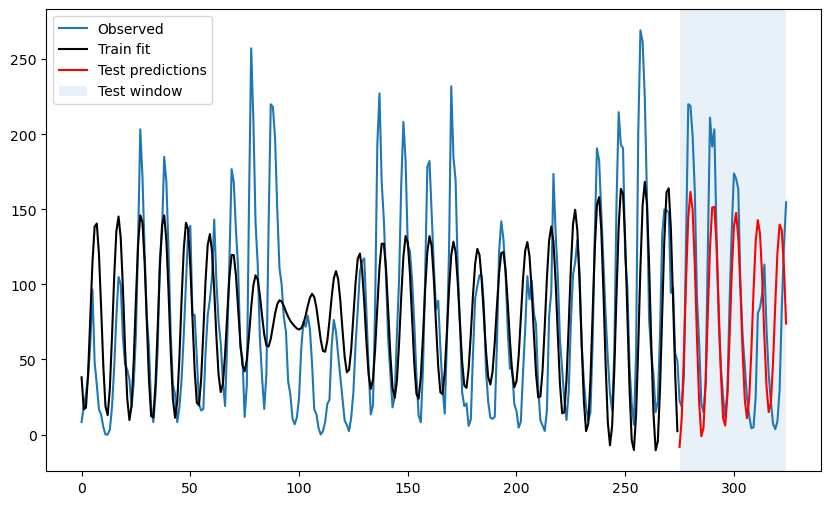

In [268]:
y_fit_train = model.predict(X_train)
plt.figure(figsize=(10, 6))
plt.plot(y, label='Observed')
plt.plot(np.arange(len(y_fit_train)), y_fit_train, color='black', label='Train fit')
plt.plot(np.arange(n - n_test, n), y_pred_test, color='red', label='Test predictions')
plt.axvspan(n - n_test, n - 1, alpha=0.1, label='Test window')
plt.legend()
plt.show()

## Discrete Fourier Transform

For a dataset $y_0, \dots, y_{n-1}$, its DFT is $b_0, b_1, \dots, b_{n-1}$ where
\begin{equation*}
   b_j = \sum_{t=0}^{n-1} y_t \exp \left(-\frac{2 \pi i j t}{n} \right).
\end{equation*}
for $j = 0, 1, \dots, n-1$. In other words, $b_j$ is a complex number with real part $\sum_t y_t \cos(2 \pi (j/n) t)$ and imaginary part $-\sum_t y_t \sin(2 \pi (j/n) t)$. 

In [ ]:
y = np.array([1, -5, 3, 10, -5, 1, 6])
dft_y = np.fft.fft(y)
print(dft_y)
b0 = np.sum(y)
print(b0)
n = len(y)
#Here is the formula for calculating the real and imaginary parts of b2:
f = 3/n
cosvec = np.cos(2 * np.pi * f * np.arange(n))
sinvec = np.sin(2 * np.pi * f * np.arange(n))
b_cos = np.sum(y * cosvec)
b_sin = np.sum(y * sinvec)
print(b_cos, b_sin) #the real part of DFT is b_cos and the imaginary part is -b_sin (note the negative sign for the imaginary part)

## Orthogonality of Sinusoids at Fourier Frequencies

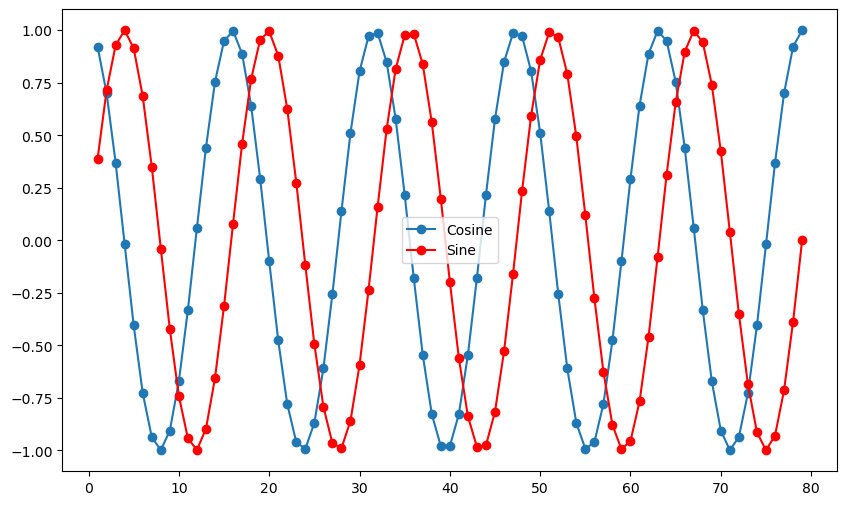

8.43769498715119e-15
-2.809572282159702e-16
39.49999999999999
39.5
-4.388782419329049e-15


In [269]:
n = 79
f = 5/n
t = np.arange(1, n+1)
cos_t = np.cos(2 * np.pi * f * t)
sin_t = np.sin(2 * np.pi * f * t)
plt.figure(figsize = (10, 6))
plt.plot(t, cos_t, '-o', label = 'Cosine')
plt.plot(t, sin_t, '-o', color = 'red', label = 'Sine')
plt.legend()
plt.show()
print(np.sum(cos_t)) #should be zero if f is a Fourier frequency
print(np.sum(sin_t)) #should be zero if f is a Fourier frequency
print(np.sum(cos_t ** 2)) #should equal n/2 if f is a Fourier frequency
print(np.sum(sin_t ** 2)) #should equal n/2 if f is a Fourier frequency
print(np.sum(cos_t * sin_t)) #should be zero if f is a Fourier frequency

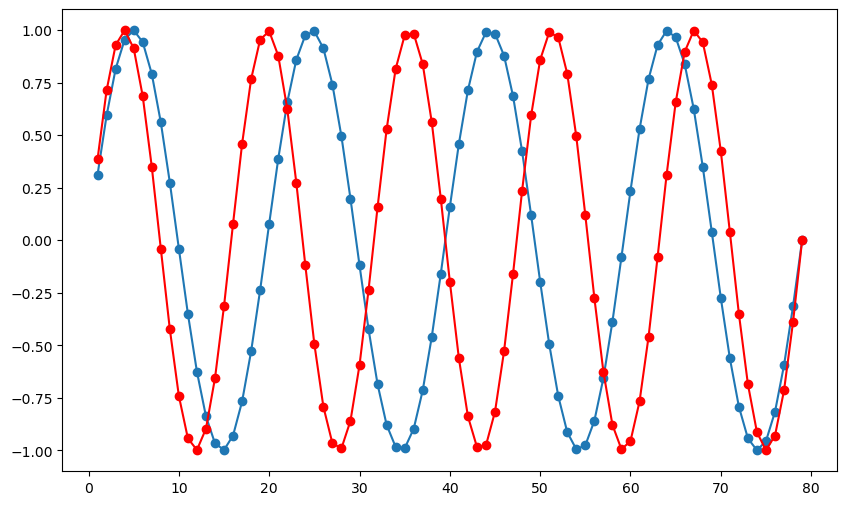

2.5743296383495824e-14


In [273]:
f1 = 4/n
f2 = 5/n
cos_f1 = np.cos(2 * np.pi * f1 * t)
sin_f1 = np.sin(2 * np.pi * f1 * t)
cos_f2 = np.cos(2 * np.pi * f2 * t)
sin_f2 = np.sin(2 * np.pi * f2 * t)
plt.figure(figsize = (10, 6))
y1 = sin_f1
y2 = sin_f2
plt.plot(t, y1, '-o')
plt.plot(t, y2, '-o', color = 'red')
plt.show()
print(sum(y1 * y2)) #should equal zero if f1 and f2 are distinct Fourier frequencies



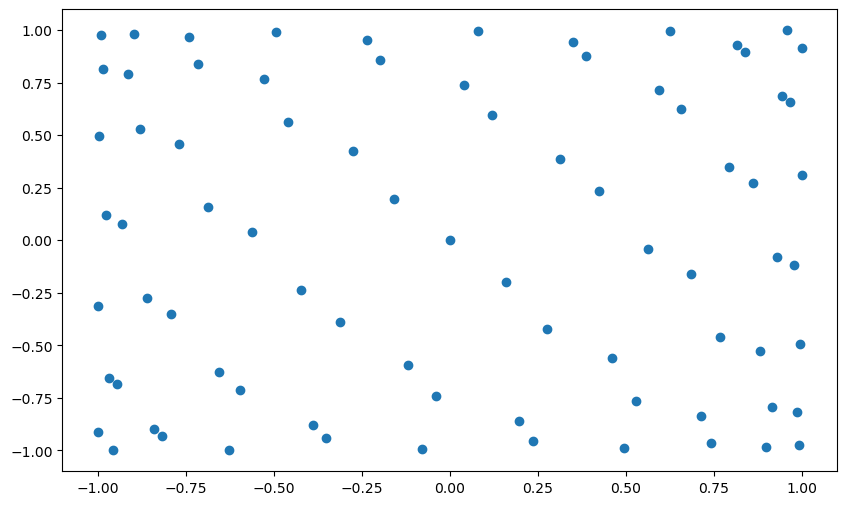

In [274]:
plt.figure(figsize = (10, 6))
plt.scatter(y1, y2) #if f1 and f2 are distinct Fourier frequencies, there should be no linear trend in this scatter plot